## Download and unzip data

In [ ]:
# https://drive.google.com/drive/folders/1G83TuEQEs1Y4-ttaXxywWeARF3HzA4JL?usp=sharing

In [ ]:
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1G83TuEQEs1Y4-ttaXxywWeARF3HzA4JL' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1G83TuEQEs1Y4-ttaXxywWeARF3HzA4JL" -O data/image && rm -rf /tmp/cookies.txt

In [ ]:
# !wget 'http://www.cis.um.edu.mo/research/shelldataset//static/new_shell_images_2nd.zip'
# !wget 'cis.um.edu.mo/research/shelldataset//static/new_shell_images_2nd.zip'
# !wget --no-check-certificate 'https://drive.google.com/drive/folders/1G83TuEQEs1Y4-ttaXxywWeARF3HzA4JL?usp=sharing' -O 'data/image'

In [ ]:
# !unzip './data/new_shell_images_2nd.zip' -d 'data/image'

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import  os 
from  random import shuffle
# from tqdm import tqdm
# import cv2
import glob as glob
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16

from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from keras import optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import re
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg

from keras.models import load_model

In [2]:
tf.__version__

'2.2.0'

## Initial inspection of data

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
img_dir = '/home/atlas/Atlas/Bishwa/data/image'

In [4]:
all_species = []
for y in os.listdir(img_dir):
    split = y.split('_')
    species = split[0] + ' ' + split[1]
    if species.lower() not in all_species:
        all_species.append(species.lower())


In [5]:
len(all_species)

7894

In [6]:
all_species[0]

'conus saharicus'

- As mentioned there are 7894 labels

In [7]:
im = Image.open(img_dir+'/Aandara_consociata_10_A.jpg')
print("Image size: ", im.size)

Image size:  (400, 300)


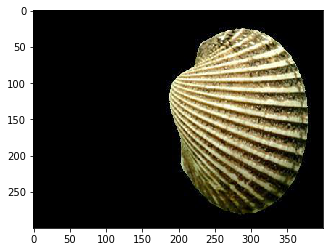

In [8]:
img=mpimg.imread(img_dir+'/Aandara_consociata_10_A.jpg')
imgplot = plt.imshow(img)
plt.show()

## Creating dataset

In [9]:
def label_img(img):
    for y in os.listdir(img_dir):
        split = y.split('_')
        label = split[0] + ' ' + split[1]
    return label

def create_train_data():
    data = []
    for img in tqdm(os.listdir(img_dir)):
        label = label_img(img)
        path = os.path.join(img_dir,img)
        input_img = cv2.imread(path,cv2.IMREAD_COLOR)
        if input_img is not None:
            img = cv2.resize(input_img, (IMG_SIZE,IMG_SIZE))
            data.append([np.array(img), np.array(label)])
        else:
            print("image not loaded")


    shuffle(data)
    np.save('data.npy', data)
    return data

In [10]:
def create_dataframe():
    image_dict = {}
    image_dict['image'] = []
    image_dict['label'] = []
  
  # for img in tqdm(os.listdir(img_dir)):
  #   label = label_img(img)
  #   image_dict['label'].append(label)

    for imagepath in glob.glob(img_dir+'/*.jpg'):
        image = imagepath.split("/")[7]
        image_dict['image'].append(image)
        split = image.split('_')
        label = split[0] + ' ' + split[1]
#         split = image.split('.')
#         label =  split[0]
        image_dict['label'].append(label)
    df = pd.DataFrame.from_dict(image_dict)
    return df

In [11]:
for imagepath in glob.glob(img_dir+'/*.jpg'):
    image = imagepath.split("/")
    print(image)
    break

['', 'home', 'atlas', 'Atlas', 'Bishwa', 'data', 'image', 'Conus_saharicus_1_B.jpg']


In [12]:
data = create_dataframe()
data.head()

,image,label
0,Conus_saharicus_1_B.jpg,Conus saharicus
1,Schizoplax_brandtii_4_A.jpg,Schizoplax brandtii
2,Babynonia_areolata_13_B.jpg,Babynonia areolata
3,Heleobia_australis_3_B.jpg,Heleobia australis
4,Arthritica_helmsi_1_B.jpg,Arthritica helmsi


In [13]:
data.iloc[4]

image    Arthritica_helmsi_1_B.jpg
label            Arthritica helmsi
Name: 4, dtype: object

In [14]:
data.shape

(59244, 2)

In [15]:
# data.to_csv('/home/atlas/Atlas/Bishwa/data/data.csv', index = False, header=True)

In [16]:
# j = data.to_json()

In [17]:
# import json
# with open('/home/atlas/Atlas/Bishwa/data/data.json', 'w') as f:
#     json.dump(j, f)

In [18]:
len(data['label'].unique())

7894

In [19]:
batch_size = 128
epochs = 10
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [20]:
train_data, valid_data = train_test_split(data, test_size=0.2,stratify=data['label'])

In [21]:
# valid_data, test_data = train_test_split(valid_data, test_size=0.15)

In [22]:
# X_train, X_test, y_train, y_test = train_test_split(data['image'], data['label'], test_size=0.15,stratify=data['label'])

In [23]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [24]:
train_data_gen = train_image_generator.flow_from_dataframe(
                                                          dataframe = train_data, 
                                                          x_col = "image",
                                                          y_col = "label",
                                                          batch_size=batch_size,
                                                           directory=img_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, 
                                                           IMG_WIDTH),
                                                           class_mode='categorical')
train_data_gen

Found 47395 validated image filenames belonging to 7894 classes.


In [25]:
label_dict = train_data_gen.class_indices

In [26]:
valid_data_gen = validation_image_generator.flow_from_dataframe(
                                                          dataframe = valid_data, 
                                                          x_col = "image",
                                                          y_col = "label",
                                                           directory=img_dir,
                                                           shuffle=False,
                                                           target_size=(IMG_HEIGHT, 
                                                           IMG_WIDTH),
                                                           class_mode='categorical')
valid_data_gen

Found 11849 validated image filenames belonging to 5719 classes.


In [24]:
# test_data_gen = validation_image_generator.flow_from_dataframe(
#                                                           dataframe = test_data, 
#                                                           x_col = "image",
#                                                           y_col = None,
#                                                            directory=img_dir,
#                                                            shuffle=False,
#                                                            target_size=(IMG_HEIGHT, 
#                                                            IMG_WIDTH),
#                                                            class_mode=None)
# valid_data_gen

## Simple baseline model

In [32]:
def model_1():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(224, 224 ,3)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(.6))
  # model.add(Dense(128, activation='relu'))
 
    model.add(Dense(7894, activation='softmax'))

    return model

In [33]:
model = model_1()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 108, 108, 128)     73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 27, 27, 128)      

In [35]:
model = model_1()

model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=['accuracy'])

In [38]:
history = model.fit(train_data_gen,steps_per_epoch=train_data_gen.n//train_data_gen.batch_size,
                    epochs=10)
#                    validation_data=valid_data_gen,
#                    validation_steps=valid_data_gen.n//valid_data_gen.batch_size)

Epoch 1/10
370/370 [==============================] - 190s 514ms/step - loss: 7.6006 - accuracy: 0.0418
Epoch 2/10
370/370 [==============================] - 191s 516ms/step - loss: 6.2047 - accuracy: 0.1157
Epoch 3/10
370/370 [==============================] - 191s 516ms/step - loss: 5.0347 - accuracy: 0.2001
Epoch 4/10
370/370 [==============================] - 191s 516ms/step - loss: 4.1269 - accuracy: 0.2787
Epoch 5/10
370/370 [==============================] - 191s 516ms/step - loss: 3.3970 - accuracy: 0.3540
Epoch 6/10
370/370 [==============================] - 191s 516ms/step - loss: 2.8056 - accuracy: 0.4172
Epoch 7/10
370/370 [==============================] - 191s 516ms/step - loss: 2.3460 - accuracy: 0.4798
Epoch 8/10
370/370 [==============================] - 191s 516ms/step - loss: 1.9736 - accuracy: 0.5372
Epoch 9/10
370/370 [==============================] - 191s 516ms/step - loss: 1.6860 - accuracy: 0.5872
Epoch 10/10
370/370 [==============================] - 191s 516m

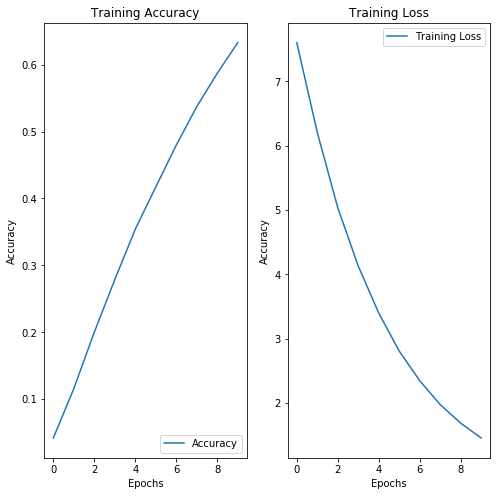

In [44]:
acc = history.history['accuracy']
loss=history.history['loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
model.fit_generator(
    train_data_gen,
    # STEP_SIZE_TRAIN=train_data_gen.n//train_data_gen.batch_size,
    # STEP_SIZE_VALID=valid_data_gen.n//valid_data_gen.batch_size,
    epochs=epochs,
    # validation_data=valid_data_gen,
    # validation_steps=5)
)

In [ ]:
model.save('model-01.h5')

In [ ]:
model = model_1()
model.compile(optimizers.rmsprop(lr=0.0001),
loss="categorical_crossentropy", metrics=["accuracy"])
STEP_SIZE_TRAIN=train_data_gen.n//train_data_gen.batch_size
STEP_SIZE_VALID=valid_data_gen.n//valid_data_gen.batch_size
history = model.fit_generator(generator=train_data_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_data_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    )

In [ ]:
model.save('model.h5')

In [ ]:
# model = model_1()
# model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.Adadelta(),
#               metrics=['accuracy'])

# history = model.fit(X, y,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           )
# score = model.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

## Trying VGG16 pretrained model

In [21]:
from keras.applications.vgg16 import VGG16


def create_model():
    model_vgg = VGG16(weights='imagenet', include_top=False,input_shape=(150,150,3))
  # flat1 = Flatten()(model.outputs)
  # class1 = Dense(1024, activation='relu')(flat1)
    for layers in model_vgg.layers:
        layers.trainable=False
        
    max_1 = MaxPooling2D(pool_size=(2,2))(model_vgg.layers[-1].output)
    flat1 = Flatten()(max_1)
    dense_1 = Dense(1024, activation='relu')(flat1)
    output = Dense(7894, activation='softmax')(dense_1)
    
    model = Model(inputs=model_vgg.inputs, outputs=output)

    return model

model = create_model()

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0  

In [22]:
# history = model.fit_generator(
#     train_data_gen.flow(X, y, batch_size=batch_size),
#     steps_per_epoch=X.shape[0] // batch_size,
#     epochs=epochs,
#     # validation_data=(x_test, y_test),
#     callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc', save_best_only=True)]
# )
history = model.fit(train_data_gen,steps_per_epoch=train_data_gen.n//train_data_gen.batch_size,epochs=2,
                   validation_data=valid_data_gen,
                   validation_steps=valid_data_gen.n//valid_data_gen.batch_size)


Epoch 1/2
1481/1481 [==============================] - 107s 72ms/step - loss: 7.9193 - accuracy: 0.0253
Epoch 2/2
1481/1481 [==============================] - 105s 71ms/step - loss: 5.7266 - accuracy: 0.1077


In [25]:
model.save('v1.00.vgg-model.h5')

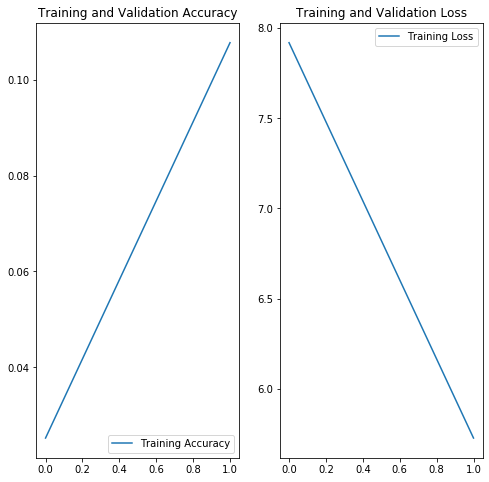

In [24]:
acc = history.history['accuracy']

# val_acc = history.history['val_accuracy']

loss=history.history['loss']
# val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Inference

In [ ]:
model = load_model('model.h5')

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

img = cv2.imread('/content/drive/My Drive/test/new_shell_images_2nd/img/Aandara_consociata_10_A.jpg')
img = cv2.resize(img,(150,150))
img = np.reshape(img,[150, 150, 1])

classes = model.predict_classes(img)

print(classes)

# Mobile net

In [27]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras import optimizers

In [28]:
class Mobile_net(Model):
    def __init__(self):
        super(Mobile_net, self).__init__()
        self.base_model = MobileNet(weights='imagenet',include_top=False, pooling="avg", input_shape=(224,224,3))
        # self.global_pool = GlobalAveragePooling2D()
        self.dense_1 = Dense(1024, activation='relu')
        self.dense_2 = Dense(512, activation='relu')
        self.dense_3 =  Dense(7894, activation='softmax')

    
    def call(self, x):
        x = self.base_model(x)
        # x = self.global_pool(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return x

In [29]:
model_1 = Mobile_net()

In [30]:
model_1.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

In [31]:
history = model_1.fit(train_data_gen,steps_per_epoch=train_data_gen.n//train_data_gen.batch_size,epochs=2)

Epoch 1/2
370/370 [==============================] - 218s 589ms/step - loss: 7.6765 - accuracy: 0.0262
Epoch 2/2
370/370 [==============================] - 220s 594ms/step - loss: 5.1884 - accuracy: 0.1071


In [ ]:
model_1.evaluate()

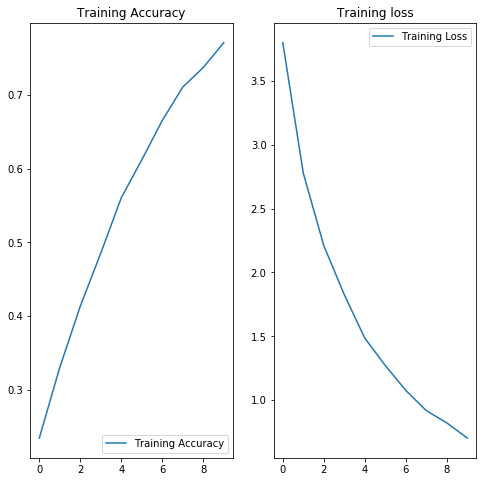

In [72]:
acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

loss=history.history['loss']
# val_loss=history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training loss')
plt.show()

In [32]:
model_1.save_weights('/home/atlas/Atlas/Bishwa/shell-identification-1-/models/v1.00.mobile-net')

make prediction

In [33]:
model_1.load_weights('/home/atlas/Atlas/Bishwa/shell-identification-1-/models/v1.00.mobile-net')

In [34]:
model_1.summary()

Model: "mobile_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 1024)              3228864   
_________________________________________________________________
dense (Dense)                multiple                  1049600   
_________________________________________________________________
dense_1 (Dense)              multiple                  524800    
_________________________________________________________________
dense_2 (Dense)              multiple                  4049622   
Total params: 8,852,886
Trainable params: 8,830,998
Non-trainable params: 21,888
_________________________________________________________________


In [41]:
# !pip install opencv-python

In [35]:
from keras.preprocessing.image import img_to_array
import numpy as np
import cv2

In [36]:
img = img_dir+'/Arthritica_helmsi_1_B.jpg'
image = cv2.imread(img)
image = cv2.resize(image, (224, 224))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
predict = model_1.predict(image)

In [37]:
label = np.argmax(predict)
labelName = list(label_dict.keys())[label]
print("Label name:", labelName)

Label name: Dulcina karubari


In [38]:
label_dict_inv = {v:k for k,v in label_dict.items()}

In [39]:
label_dict_inv[label]

'Dulcina karubari'

In [40]:
import json

In [41]:
with open('/home/atlas/Atlas/Bishwa/shell-identification-1-/src/labels/v1.00.mobile-net-label.json', 'w') as f:
    json.dump(label_dict, f)

In [42]:
!pwd

/home/atlas/Atlas/Bishwa


In [43]:
cd shell-identification-1-/src/

/home/atlas/Atlas/Bishwa/shell-identification-1-/src


In [45]:
!python predict.py

2020-07-14 14:15:10.896143: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-07-14 14:15:10.923104: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2020-07-14 14:15:10.924653: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:04:00.0 name: GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2020-07-14 14:15:10.926173: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 2 with properties: 
pciBusID: 0000:05:00.0 name: GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2020-07-14